In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

In [ ]:
from pathlib import Path

video_path = Path("/home/keli/VideoEdit/test/basketball.mp4")

In [18]:
video_path.exists()

False

In [5]:
len(frames)

0

In [7]:
from torchvision.io import read_video
frames, _, _ = read_video(str(video_path), output_format="TCHW")

img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])

plot(img1_batch)

/home/keli/VideoEdit/.venv/lib/python3.12/site-packages/torchvision/io/_video_deprecation_warning.py:9: UserWarning: The video decoding and encoding capabilities of torchvision are deprecated from version 0.22 and will be removed in version 0.24. We recommend that you migrate to TorchCodec, where we'll consolidate the future decoding/encoding capabilities of PyTorch: https://github.com/pytorch/torchcodec
  warnings.warn(


IndexError: index 100 is out of bounds for dimension 0 with size 0

In [4]:
from torchvision.models.optical_flow import Raft_Large_Weights

weights = Raft_Large_Weights.DEFAULT
transforms = weights.transforms()


def preprocess(img1_batch, img2_batch):
    img1_batch = F.resize(img1_batch, size=[520, 960], antialias=False)
    img2_batch = F.resize(img2_batch, size=[520, 960], antialias=False)
    return transforms(img1_batch, img2_batch)


img1_batch, img2_batch = preprocess(img1_batch, img2_batch)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 520, 960]), dtype = torch.float32


In [6]:
from torchvision.models.optical_flow import raft_large

# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

type = <class 'list'>
length = 12 = number of iterations of the model


In [7]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 520, 960]) = (N, 2, H, W)
min = -3.899899959564209, max = 6.401098728179932


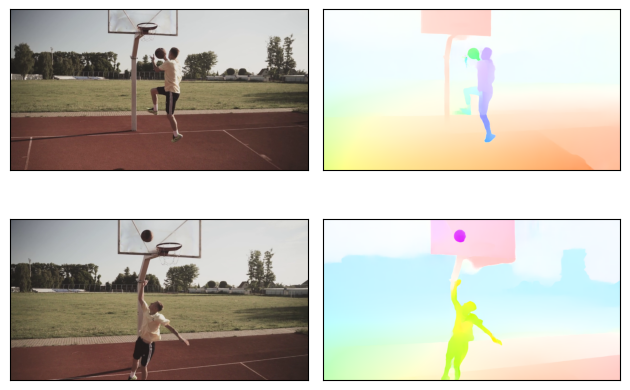

In [8]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

In [10]:
from torchvision.io import write_jpeg
for i, (img1, img2) in enumerate(zip(frames, frames[1:])):
    # Note: it would be faster to predict batches of flows instead of individual flows
    img1, img2 = preprocess(img1, img2)

    list_of_flows = model(img1.unsqueeze(0).to(device), img2.unsqueeze(0).to(device))
    predicted_flow = list_of_flows[-1][0]
    flow_img = flow_to_image(predicted_flow).to("cpu")
    output_folder = "/tmp/"  # Update this to the folder of your choice
    write_jpeg(flow_img, output_folder + f"predicted_flow_{i}.jpg")

In [11]:
! ffmpeg -f image2 -framerate 30 -i /tmp/predicted_flow_%d.jpg -loop -1 flow.gif

ffmpeg version 7.0.2-static https://johnvansickle.com/ffmpeg/  Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gmp --enable-libgme --enable-gray --enable-libaom --enable-libfribidi --enable-libass --enable-libvmaf --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librubberband --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libvorbis --enable-libopus --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libdav1d --enable-libxvid --enable-libzvbi --enable-libzimg
  libavutil      59.  8.100 / 59.  8.100
  libavcodec     61.  3.100 / 61.  3.100
  libavformat   